In [1]:

import sys
sys.path.append("/workspace")
sys.path


['/usr/local/lib/python312.zip',
 '/usr/local/lib/python3.12',
 '/usr/local/lib/python3.12/lib-dynload',
 '',
 '/usr/local/lib/python3.12/site-packages',
 '/workspace/src',
 '/workspace']

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
from qtb.analytics.analyze import QLogAnalyzer

QLOG_FILE = r"/workspace/runs/d1/e1/client/cb2fe2d478514ec4.qlog"
print("Analyzing:", QLOG_FILE)

qla = QLogAnalyzer(QLOG_FILE)


Analyzing: /workspace/runs/d1/e1/client/cb2fe2d478514ec4.qlog


In [3]:

cwnd_df = pd.DataFrame(qla.analyze_cwnd())
rtt_df  = pd.DataFrame(qla.analyze_rtt())
loss_df = pd.DataFrame(qla.analyze_loss())
goodput = qla.analyze_goodput()

cwnd_df.head(), rtt_df.head(), loss_df.head(), goodput


(    cwnd  bytes_in_flight          time
 0  12000              524  1.764637e+12
 1  12524                0  1.764637e+12
 2  12524                0  1.764637e+12
 3  12524              105  1.764637e+12
 4  12524              357  1.764637e+12,
            time    min_rtt  smoothed_rtt  latest_rtt  rtt_variance
 0  1.764637e+12        NaN           NaN         NaN           NaN
 1  1.764637e+12  16.771542     16.771542   16.771542      8.385771
 2  1.764637e+12        NaN           NaN         NaN           NaN
 3  1.764637e+12        NaN           NaN         NaN           NaN
 4  1.764637e+12        NaN           NaN         NaN           NaN,
            time  packet_number packet_type trigger
 0  1.764637e+12             39        None    None
 1  1.764637e+12             49        None    None
 2  1.764637e+12             66        None    None
 3  1.764637e+12            120        None    None
 4  1.764637e+12            130        None    None,
 {'bytes': 1059548,
  'duration

In [4]:

if not cwnd_df.empty:
    t0 = cwnd_df['time'].iloc[0]
    cwnd_df['time_rel'] = (cwnd_df['time'] - t0) / 1000.0

if not rtt_df.empty:
    t0 = rtt_df['time'].iloc[0]
    rtt_df['time_rel'] = (rtt_df['time'] - t0) / 1000.0

loss_df


,time,packet_number,packet_type,trigger
0,1.764637e+12,39,None,None
1,1.764637e+12,49,None,None
2,1.764637e+12,66,None,None
3,1.764637e+12,120,None,None
4,1.764637e+12,130,None,None
...,...,...,...,...
80,1.764637e+12,2861,None,None
81,1.764637e+12,2936,None,None
82,1.764637e+12,2985,None,None
83,1.764637e+12,2989,None,None


In [5]:

import json
import os

# Derive matching TCP JSON: <basename>_tcp.json
tcp_path = os.path.join(
    os.path.dirname(QLOG_FILE),
    os.path.splitext(os.path.basename(QLOG_FILE))[0] + "_tcp.json",
)

try:
    with open(tcp_path, "r", encoding="utf-8") as f:
        tcp_raw = json.load(f)
    tcp_df = pd.DataFrame(tcp_raw)
except FileNotFoundError:
    print("No TCP stats found at", tcp_path)
    tcp_df = pd.DataFrame()

if not tcp_df.empty:
    # Normalize time (relative, like QUIC)
    # TCP log uses 'timestamp' in seconds.  [oai_citation:0‡b00120c0becc2157_tcp.json](sediment://file_00000000c7c471fd83918ee1a9bcf1aa)
    tcp_df["timestamp"] = pd.to_numeric(tcp_df["timestamp"], errors="coerce")
    t0_tcp = tcp_df["timestamp"].iloc[0]
    tcp_df["time_rel"] = tcp_df["timestamp"] - t0_tcp

    # Fill nulls with 0 for robustness (cwnd, throughput, etc.)
    for col in ["cwnd", "tx_throughput_bps", "rx_throughput_bps"]:
        if col in tcp_df.columns:
            tcp_df[col] = tcp_df[col].fillna(0)

    # Precompute throughput in Mbps (prefer RX, fall back to TX)
    if "rx_throughput_bps" in tcp_df.columns:
        base = "rx_throughput_bps"
    elif "tx_throughput_bps" in tcp_df.columns:
        base = "tx_throughput_bps"
    else:
        base = None

    if base is not None:
        tcp_df["throughput_mbps"] = tcp_df[base] / 1e6
                                      
    MSS = 1448
    tcp_df["cwnd"] = tcp_df["cwnd"] * 1488
else:
    print("tcp_df is empty; TCP plots will be skipped.")


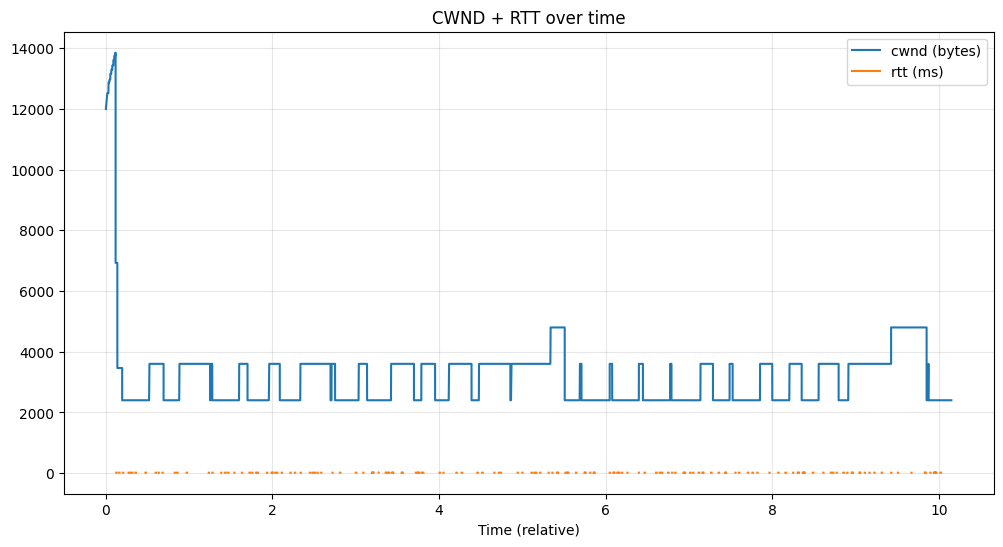

In [6]:

plt.figure(figsize=(12,6))

if not cwnd_df.empty:
    plt.plot(cwnd_df['time_rel'], cwnd_df['cwnd'], label="cwnd (bytes)")

if not rtt_df.empty:
    plt.plot(rtt_df['time_rel'], rtt_df['smoothed_rtt'], label="rtt (ms)")

plt.grid(True, alpha=0.3)
plt.legend()
plt.title("CWND + RTT over time")
plt.xlabel("Time (relative)")
plt.show()


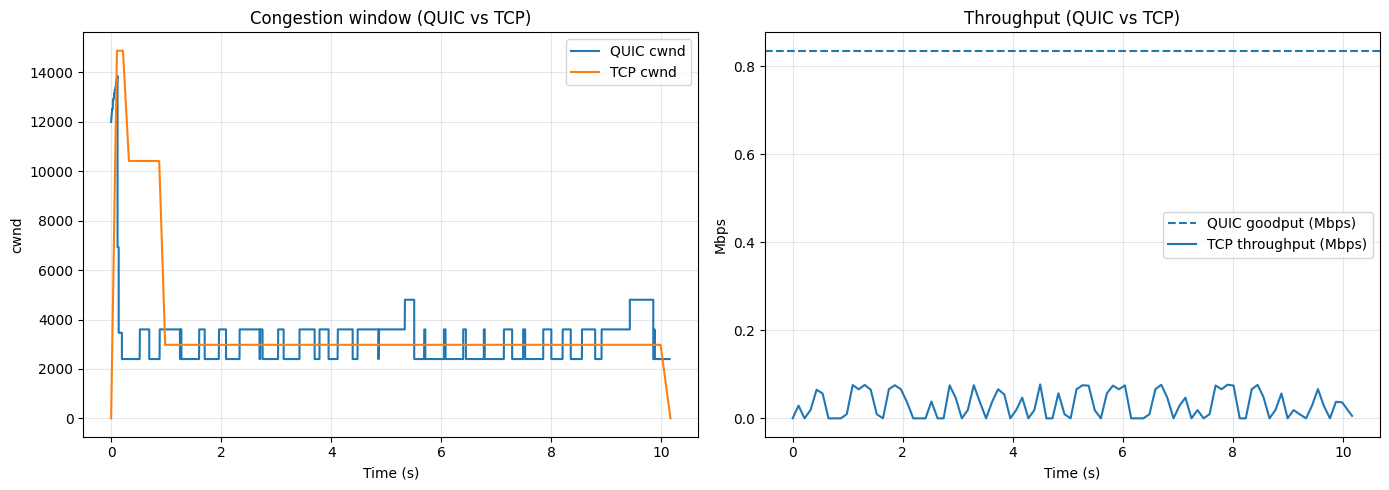

In [7]:

# Side-by-side: QUIC vs TCP for cwnd and throughput

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ---------------- CWND: QUIC vs TCP ----------------
ax_cwnd = axes[0]

if not cwnd_df.empty:
    ax_cwnd.plot(cwnd_df["time_rel"], cwnd_df["cwnd"], label="QUIC cwnd")

if "tcp_df" in globals() and not tcp_df.empty and "time_rel" in tcp_df and "cwnd" in tcp_df.columns:
    ax_cwnd.plot(tcp_df["time_rel"], tcp_df["cwnd"], label="TCP cwnd")

ax_cwnd.set_title("Congestion window (QUIC vs TCP)")
ax_cwnd.set_xlabel("Time (s)")
ax_cwnd.set_ylabel("cwnd")
ax_cwnd.grid(True, alpha=0.3)
ax_cwnd.legend()

# ---------------- Throughput: QUIC vs TCP ----------------
ax_tp = axes[1]

# QUIC throughput:
# - If analyze_goodput() returns a series, plot it.
# - Otherwise, fall back to a flat horizontal line at average goodput_mbps.
quic_label = "QUIC goodput (Mbps)"
quic_avg = 0.0

if isinstance(goodput, dict):
    quic_avg = float(goodput.get("goodput_mbps", 0.0))

    if "series" in goodput:
        quic_series = pd.DataFrame(goodput["series"])
        if not quic_series.empty:
            # Try to normalize time if there's a 'time' column
            if "time" in quic_series.columns and "time_rel" not in quic_series.columns:
                t0 = quic_series["time"].iloc[0]
                quic_series["time_rel"] = quic_series["time"] - t0

            # Guess a throughput column name
            if "throughput_mbps" in quic_series.columns:
                ycol = "throughput_mbps"
            elif "throughput_bps" in quic_series.columns:
                ycol = "throughput_bps"
                quic_series[ycol] = quic_series[ycol] / 1e6
            else:
                # Last numeric column as fallback
                ycol = quic_series.select_dtypes("number").columns[-1]

            ax_tp.plot(quic_series["time_rel"], quic_series[ycol], label=quic_label)
        else:
            ax_tp.axhline(quic_avg, linestyle="--", label=quic_label)
    else:
        ax_tp.axhline(quic_avg, linestyle="--", label=quic_label)
else:
    ax_tp.axhline(0.0, linestyle="--", label=quic_label)

# TCP throughput: use precomputed throughput_mbps from 3b
if "tcp_df" in globals() and not tcp_df.empty and "throughput_mbps" in tcp_df.columns:
    if "time_rel" not in tcp_df.columns and "timestamp" in tcp_df.columns:
        t0_tcp = tcp_df["timestamp"].iloc[0]
        tcp_df["time_rel"] = tcp_df["timestamp"] - t0_tcp

    ax_tp.plot(
        tcp_df["time_rel"],
        tcp_df["throughput_mbps"],
        label="TCP throughput (Mbps)",
    )

ax_tp.set_title("Throughput (QUIC vs TCP)")
ax_tp.set_xlabel("Time (s)")
ax_tp.set_ylabel("Mbps")
ax_tp.grid(True, alpha=0.3)
ax_tp.legend()

plt.tight_layout()
plt.show()


In [8]:

summary = {
    "avg_cwnd": cwnd_df["cwnd"].mean() if not cwnd_df.empty else None,
    "max_cwnd": cwnd_df["cwnd"].max() if not cwnd_df.empty else None,
    "avg_rtt": rtt_df["smoothed_rtt"].mean() if not rtt_df.empty else None,
    "loss_events": len(loss_df),
    "goodput_mbps": goodput["goodput_mbps"],
}

summary


{'avg_cwnd': np.float64(3177.2582250483824),
 'max_cwnd': np.int64(13855),
 'avg_rtt': np.float64(11.888366165606534),
 'loss_events': 85,
 'goodput_mbps': 0.8349337897990682}